In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch


## Dataset generation

In [3]:
df = pd.read_parquet("../RAGtruth/data.parquet")
df = df[df["task_type"] == "QA"]

df["labels"] = df["labels"].apply(lambda x: False if len(x) == 0 else x)
df["labels"] = df["labels"].apply(lambda x: x[0]["label_type"] if type(x) != bool else x)

# Filter rows where labels are not False
positive_labels = df[df["labels"] != False]
llama = df[df["model"].str.contains("llama")]

def split_dataframe(df, chunk_size = 10000): 
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks
chunks_l = split_dataframe(positive_labels, chunk_size=100)
chunks = split_dataframe(df, chunk_size=100)

# Classifier based on LLM-as-a-judge model

In [4]:
# # Read all parquet files for answer_relevancy

# unbalanced = [3, 4, 6, 7, 16]
# balanced = [4, 5, 9]

# paths = [f"../llama3-70b-8192/AR_{i}*.parquet" for i in unbalanced] + [
#     f"../llama3-70b-8192/l_AR_{i}*.parquet" for i in balanced
# ]

# answer_relevancies = []

# for path in paths:
#     answer_relevancy_files = glob.glob(path)
#     answer_relevancy = pd.concat(
#         [pd.read_parquet(f) for f in answer_relevancy_files], axis=1, ignore_index=True
#     )
#     answer_relevancy = answer_relevancy.mean(axis=1)
#     answer_relevancies.append(answer_relevancy)
# answer_relevancy = pd.concat(answer_relevancies, ignore_index=True)



# paths = [f"../llama3-70b-8192/faithful_{i}*.parquet" for i in unbalanced] + [
#     f"../llama3-70b-8192/l_faithful_{i}*.parquet" for i in balanced
# ]

# faithfulnesses = []
# for path in paths:
#     faithfulness_files = glob.glob(path)
#     faithfulness = pd.concat(
#         [pd.read_parquet(f) for f in faithfulness_files], axis=1, ignore_index=True
#     )
#     faithfulness = faithfulness.mean(axis=1)
#     faithfulnesses.append(faithfulness)

# faithfulness = pd.concat(faithfulnesses, ignore_index=True)

# temperature = pd.concat(
#     [pd.DataFrame(chunks[i]["temperature"]) for i in unbalanced]
#     + [pd.DataFrame(chunks_l[i]["temperature"]) for i in balanced],
#     ignore_index=True,
# )

In [7]:
files = glob.glob("data/data_1*.parquet")

df = pd.concat([pd.read_parquet(f) for f in files]).groupby(level=0).mean()
df = pd.concat([pd.read_parquet("data/data_3_1.parquet"), pd.read_parquet("data/data_8_1.parquet"), df])
df.drop(columns=["temperature"], inplace=True)
df.dropna(inplace=True)

X = df.drop(columns=["label"])
y = df["label"]
label_mapping = {label: idx for idx, label in enumerate(y.unique())}
y = y.map(label_mapping)

y = (y > 0).astype(int)

In [12]:
import pandas as pd
from datasets import load_dataset

dataset = load_dataset("rungalileo/ragbench", "tatqa")
tatqa = pd.DataFrame(dataset["train"])
tatqa_results = pd.concat([pd.read_parquet("data/tat_qa/data_2_1.parquet"), pd.read_parquet("data/tat_qa/data_7_1.parquet")])
tatqa_results["id"] = tatqa_results["ids"]
tatqa_results = tatqa_results.drop(columns=["ids"])
tatqa_results.dropna(subset = ['id'], inplace=True)
tatqa = tatqa.merge(tatqa_results, on="id")
tatqa[tatqa["faithfulness"] == 0]

,id,question_x,documents_x,response_x,generation_model_name,annotating_model_name,dataset_name,documents_sentences,response_sentences,sentence_support_information,...,gpt35_utilization,relevance_score,utilization_score,completeness_score,question_y,documents_y,response_y,faithfulness,faithfulness_just,answer_relevancy
3,finqa_train_1015,What was the other accounts receivable in 2019?,[The Corporation is also exposed to credit ris...,"The other accounts receivable in 2019 was $8,3...",gpt-3.5-turbo-0125,gpt-4o,tatqa_train,"[[[0a, The Corporation is also exposed to cred...","[[a, The other accounts receivable in 2019 was...",[{'explanation': 'The statement 'The other acc...,...,None,0.100000,0.100000,1.000000,None,None,None,0,The answer provides accurate calculations and ...,5
6,finqa_train_1010,Which are the components included in the net p...,[Net periodic benefit expense for our post-ret...,The components included in the net periodic be...,gpt-3.5-turbo-0125,gpt-4o,tatqa_train,"[[[0a, Net periodic benefit expense for our po...","[[a, The components included in the net period...",[{'explanation': 'The sentence lists service c...,...,None,0.200000,0.200000,1.000000,d,None,None,0,The answer is not faithful because it provides...,5
10,finqa_train_10127,What does the table show?,"[NOTE 10. EARNINGS PER SHARE [["""", ""Year Ended...",The table shows the reconciliation between bas...,gpt-3.5-turbo-0125,gpt-4o,tatqa_train,"[[[0a, NOTE 10. EARNINGS PER SHARE [["""", ""Year...","[[a, The table shows the reconciliation betwee...",[{'explanation': 'This sentence is directly su...,...,None,1.000000,0.666667,0.666667,None,None,None,0,The answer provides a correct comparison of th...,5
12,finqa_train_10112,How many years between 2017 and 2019 had endin...,"[Uncertain Tax Positions [[""(In millions)"", """"...","In 2017 and 2018, the ending unrecognized tax ...",gpt-3.5-turbo-0125,gpt-4o,tatqa_train,"[[[0a, Uncertain Tax Positions [[""(In millions...","[[a, In 2017 and 2018, the ending unrecognized...",[{'explanation': 'This sentence states that th...,...,None,0.066667,0.066667,1.000000,t,None,None,0,Some statements are not supported by the refer...,5
16,finqa_train_10004,In which year was the amount of financial inco...,"[NOTE 9 – FINANCIAL ITEMS [[""USDm"", ""2019"", ""2...","In 2019, the amount of financial income was th...",gpt-3.5-turbo-0125,gpt-4o,tatqa_train,"[[[0a, NOTE 9 – FINANCIAL ITEMS [[""USDm"", ""201...","[[a, In 2019, the amount of financial income w...",[{'explanation': 'This sentence states that in...,...,None,0.500000,0.500000,1.000000,t,None,None,0,The answer provides a calculation that is not ...,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,finqa_train_10167,What is the change in revenues from ASG from 2...,"[Revenue [["""", ""2019"", ""As a % of Revenue (1)""...",According to the context provided:\n\nThe reve...,claude-3-haiku-20240307,gpt-4o,tatqa_train,"[[[0a, Revenue [["""", ""2019"", ""As a % of Revenu...","[[a, According to the context provided:], [b, ...",[{'explanation': 'This sentence is a general t...,...,None,0.133333,0.066667,0.500000,None,None,None,0,"Some sentences lack references, and some refer...",4
322,finqa_train_10140,How many shares of the Common Stock were issue...,"[NOTE 11 - STOCK CAPITAL (Cont.) [["""", ""Decemb...","According to the context provided, on March 26...",claude-3-haiku-20240307,gpt-4o,tatqa_train,"[[[0a, NOTE 11 - STOCK CAPITAL (Cont.)], [0b, ...","[[a, According to the context provided, on Mar...",[{'explanation': 'This sentence accurately con...,...,None,0.090909,0.090909,1.000000,None,None,None,0,"The first sentence is faithful, but the second...",5
325,finqa_train_10169,Which financial years' information is shown in...,"[15. Trade and other payables [["""", ""2019"", ""2...",The financial years' information shown in the ...,claude-3-haiku-20240307,gpt-4o,tatqa_train,"[[[0a, 15. Trade and other payables [["""", ""201...","[[a, The f

In [13]:
for id, row in tatqa.iterrows():
    print(row["response_x"], row["context_x"], row["question_x"])

KeyError: 'context_x'

In [ ]:
X_I, X_eval, y_I, y_eval = train_test_split(X, y, test_size=0.2, random_state=40)
X_train, X_calibr, y_train, y_calibr = train_test_split(X_I, y_I, test_size=0.25, random_state=40)

In [ ]:
class BasicMLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(BasicMLP, self).__init__()
        self.ffnn = nn.Sequential(
            nn.Linear(input_size, 6),
            nn.ReLU(),
            nn.Linear(6, 4),
            nn.ReLU(),
            nn.Linear(4, output_size),
        )

    def forward(self, x):
        return self.ffnn(x)

In [ ]:
model = BasicMLP(X_train.shape[1], len(y.value_counts().index))
optimizer = optim.Adam(
    model.parameters(),
)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
x_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32, requires_grad=True)
y_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long)

# Create a TensorDataset
dataset = TensorDataset(x_tensor, y_tensor)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

EPOCH 1:
2.096238076686859
EPOCH 6:
2.0491836071014404
EPOCH 11:
2.0133867263793945
EPOCH 16:
1.9977125525474548
EPOCH 21:
1.9758008122444153
EPOCH 26:
1.9765361547470093
EPOCH 31:
1.9664828181266785
EPOCH 36:
1.9606168866157532
EPOCH 41:
1.9519909024238586
EPOCH 46:
1.9449637532234192
EPOCH 51:
1.9356598258018494
EPOCH 56:
1.9270538687705994
EPOCH 61:
1.9113787412643433
EPOCH 66:
1.8993296027183533
EPOCH 71:
1.8871519565582275
EPOCH 76:
1.8823427557945251
EPOCH 81:
1.8530427813529968
EPOCH 86:
1.83912992477417
EPOCH 91:
1.8230759501457214
EPOCH 96:
1.7929975986480713
EPOCH 101:
1.7767256498336792
EPOCH 106:
1.7765145897865295
EPOCH 111:
1.7532448172569275
EPOCH 116:
1.7306362390518188
EPOCH 121:
1.744530975818634
EPOCH 126:
1.7212302088737488
EPOCH 131:
1.7262367010116577
EPOCH 136:
1.6946613788604736
EPOCH 141:
1.7065783739089966
EPOCH 146:
1.6935637593269348
EPOCH 151:
1.6953627467155457
EPOCH 156:
1.711883544921875
EPOCH 161:
1.6830564141273499
EPOCH 166:
1.6946403980255127
EPOCH 1

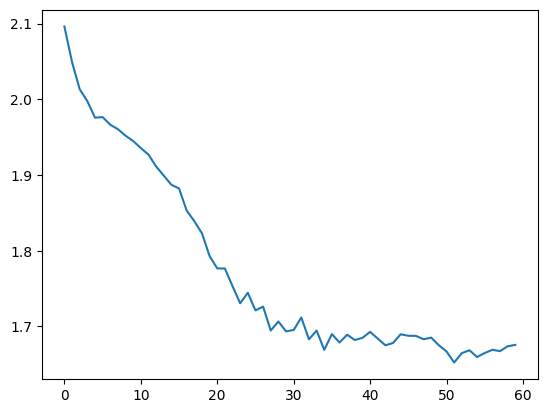

In [ ]:
EPOCHS = 300

losses = []
for epoch in range(EPOCHS):
    running_loss = 0.
    last_loss = 0.

    model.train()
    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    if epoch % 5 == 0:
        print('EPOCH {}:'.format(epoch + 1))
        losses.append(running_loss)
        print(running_loss)

plt.plot(losses)

In [ ]:
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier

log = LogisticRegression(penalty='l2')
knn = KNeighborsClassifier(n_neighbors=4)
lgbm = LGBMClassifier()

lgbm.fit(X_train, y_train)
knn.fit(X_train.values, y_train)

[LightGBM] [Info] Number of positive: 140, number of negative: 208
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15
[LightGBM] [Info] Number of data points in the train set: 348, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.402299 -> initscore=-0.395896
[LightGBM] [Info] Start training from score -0.395896
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

KNeighborsClassifier(n_neighbors=4)

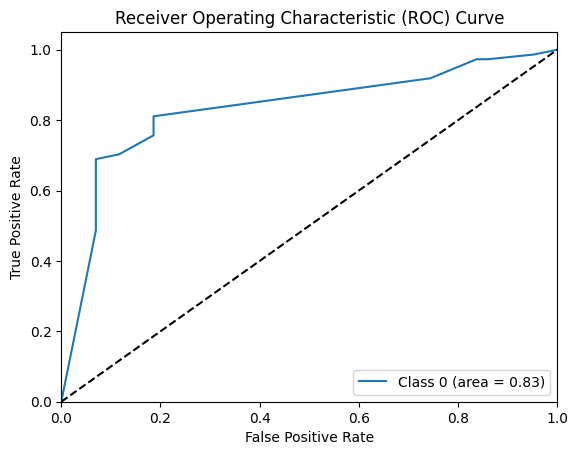

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

cm = confusion_matrix(y_eval, lgbm.predict(X_eval))
# Print classification report
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(np.unique(y_eval))

for i in range(n_classes - 1):
    fpr[i], tpr[i], _ = roc_curve(y_eval == i, lgbm.predict_proba(X_eval)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure()
for i in range(n_classes - 1):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

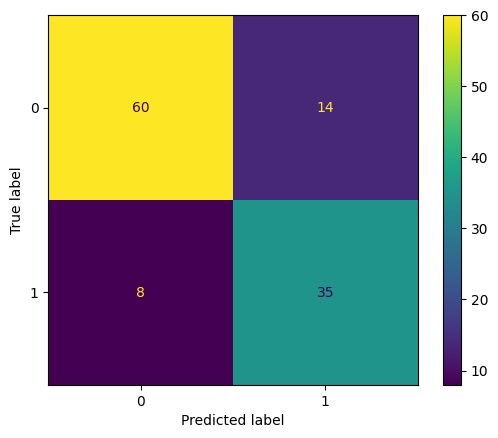

In [ ]:
ConfusionMatrixDisplay(cm).plot()

In [ ]:
X_tensor_calibr = torch.tensor(X_calibr.to_numpy(), dtype=torch.float32)
y_tensor_calibr = torch.tensor(y_calibr.to_numpy(), dtype=torch.long)
dataset = TensorDataset(X_tensor_calibr, y_tensor_calibr)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

In [ ]:
with torch.no_grad():
    running_vloss = 0.
    avg_loss = 0.
    for i, vdata in enumerate(test_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss
    
        avg_vloss = running_vloss / (i + 1)

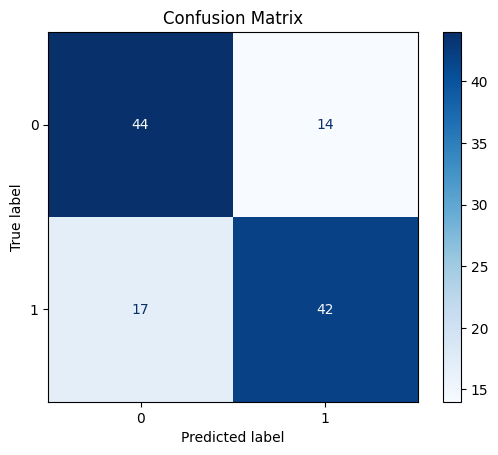

Pearson correlation coefficient: 0.4837085207486996
0.7350427350427351
              precision    recall  f1-score   support

           0       0.72      0.76      0.74        58
           1       0.75      0.71      0.73        59

    accuracy                           0.74       117
   macro avg       0.74      0.74      0.73       117
weighted avg       0.74      0.74      0.73       117

Pearson correlation coefficient for lgbm: 0.4837085207486996
Kendall's tau correlation: 0.3802365218895061
Kendall's tau correlation for lgbm: 0.3802365218895061


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, kendalltau

true_labels = []
predicted_labels = []
probs = []
# Set model to evaluation mode
model.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        # Get model outputs
        outputs = model(inputs)  # Raw logits
        
        # Apply sigmoid activation
        probabilities = F.softmax(outputs, dim=1)
        
        # Compute argmax for class prediction
        predictions = torch.argmax(probabilities, dim=1)
        
        # Store true and predicted labels
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())
        probs.extend(probabilities.cpu().numpy())

# Convert to NumPy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)
probs = np.array(probs)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig("dl.png")
plt.show()

# Compute Pearson correlation coefficient
pearson_corr, _ = pearsonr(true_labels, probs[:, 1])
print(f"Pearson correlation coefficient: {pearson_corr}")

print(accuracy_score(true_labels, predicted_labels))
# print(accuracy_score(true_labels, lgbm.predict(X_eval)))
print(classification_report(true_labels, predicted_labels))

# pearson_corr, _ = pearsonr(true_labels, lgbm.predict_proba(X_eval)[:, 1])
print(f"Pearson correlation coefficient for lgbm: {pearson_corr}")
# Compute Kendall's tau correlation
kendall_tau, _ = kendalltau(true_labels, probs[:, 1])
print(f"Kendall's tau correlation: {kendall_tau}")

# kendall_tau, _ = kendalltau(true_labels, lgbm.predict_proba(X_eval)[:, 1])
print(f"Kendall's tau correlation for lgbm: {kendall_tau}")

fpr = dict()
# tpr = dict()
# roc_auc = dict()
# n_classes = len(np.unique(y_eval))

# for i in range(n_classes - 1):
#     fpr[i], tpr[i], _ = roc_curve(y_eval == i, probs[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Plot ROC curve
# plt.figure()
# for i in range(n_classes - 1):
#     plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:0.2f})')

# # Plot ROC curve
# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc="lower right")
# plt.savefig("roc_curve.png")
# plt.show()

In [ ]:
import numpy as np

# Define the function for conformal prediction
def conformal_prediction(calibrated_probs, labels, alpha=0.05):
    """
    Perform conformal prediction with calibrated probabilities.

    Args:
        calibrated_probs (np.ndarray): Calibrated probabilities for the hold-out set (I2).
        labels (np.ndarray): Ground truth labels for the hold-out set (I2).
        test_probs (np.ndarray): Probabilities for the test sample.
        alpha (float): Risk tolerance level.

    Returns:
        prediction_set (list): Labels included in the prediction set for the test sample.
        quantile (float): The (1-alpha)-quantile of the conformity scores.
    """
    # Step 1: Compute conformity scores for the hold-out set
    conformity_scores = 1 - np.array([probs[label] for probs, label in zip(calibrated_probs, labels)])

    # Step 2: Compute the (1-alpha) quantile of the conformity score distribution
    # Include the adjustment \delta_\infty
    num_samples = len(conformity_scores)
    extended_scores = np.append(conformity_scores, float('inf'))
    quantile = np.sort(extended_scores)[int((1 - alpha) * (num_samples + 1)) - 1]

    return quantile

In [ ]:
X_tensor_eval = torch.tensor(X_eval.to_numpy(), dtype=torch.float32)
y_tensor_eval = torch.tensor(y_eval.to_numpy(), dtype=torch.long)
dataset = TensorDataset(X_tensor_eval, y_tensor_eval)
true_test_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

In [ ]:
mean_p = probs[true_labels == 1][:, 1].mean()

0.7360870838165283


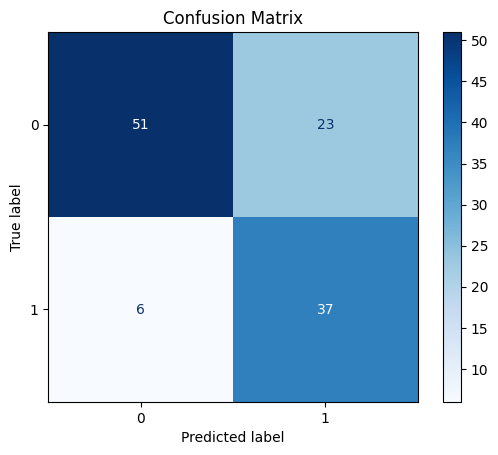

Pearson correlation coefficient: 0.5728827499016765
0.7521367521367521
              precision    recall  f1-score   support

           0       0.89      0.69      0.78        74
           1       0.62      0.86      0.72        43

    accuracy                           0.75       117
   macro avg       0.76      0.77      0.75       117
weighted avg       0.79      0.75      0.76       117



In [ ]:
eval_true_labels = []
eval_predicted_labels = []
eval_probs = []
# Set model to evaluation mode
import torch.nn.functional as F
model.eval()


q = conformal_prediction(probs, true_labels, alpha=0.1)
print(q)
with torch.no_grad():
    for inputs, labels in true_test_loader:
        # Get model outputs
        outputs = model(inputs)  # Raw logits
        
        # Apply sigmoid activation
        probabilities = F.softmax(outputs, dim=1)
        
        predictions = probabilities[:, 1] >= 1 - q
        # Compute argmax for class prediction
        # predictions = torch.argmax(probabilities, dim=1)
        
        # Store true and predicted labels
        eval_true_labels.extend(labels.cpu().numpy())
        eval_predicted_labels.extend(predictions.cpu().numpy())
        eval_probs.extend(probabilities.cpu().numpy())

eval_true_labels = np.array(eval_true_labels)
eval_predicted_labels = np.array(eval_predicted_labels)
eval_probs = np.array(eval_probs)

cm = confusion_matrix(eval_true_labels, eval_predicted_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig("dl.png")
plt.show()

# Compute Pearson correlation coefficient
pearson_corr, _ = pearsonr(eval_true_labels, eval_probs[:, 1])
print(f"Pearson correlation coefficient: {pearson_corr}")

print(accuracy_score(eval_true_labels, eval_predicted_labels))
# print(accuracy_score(true_labels, lgbm.predict(X_eval)))
print(classification_report(eval_true_labels, eval_predicted_labels))



## True test set

In [ ]:
test_n = 8
faithfulness_files = glob.glob(f"../llama3-70b-8192/faithful_{test_n}*")
ar_files = glob.glob(f"../llama3-70b-8192/AR_{test_n}*")


faithfulness = pd.concat(
    [pd.read_parquet(f) for f in faithfulness_files], axis=1, ignore_index=True
)
faithfulness = faithfulness.mean(axis=1)
ar = pd.concat(
    [pd.read_parquet(f) for f in ar_files], axis=1, ignore_index=True
)
ar = ar.mean(axis=1)

temperature =  pd.DataFrame(chunks[test_n]["temperature"])

X_test = pd.concat([temperature, ar, faithfulness], axis=1)
y_test = pd.concat(
    [
        chunks[test_n]["labels"],
    ],
    ignore_index=True,
)

y_test = y_test.map(label_mapping)

y_test = (y_test > 0).astype(int)

NameError: name 'chunks' is not defined

In [ ]:
x_tensor_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_tensor_test = torch.tensor(y_test.to_numpy(), dtype=torch.long)
dataset = TensorDataset(x_tensor_test, y_tensor_test)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

Pearson correlation coefficient: 0.24051746628468976
Kendall's tau correlation: 0.1786448538301852


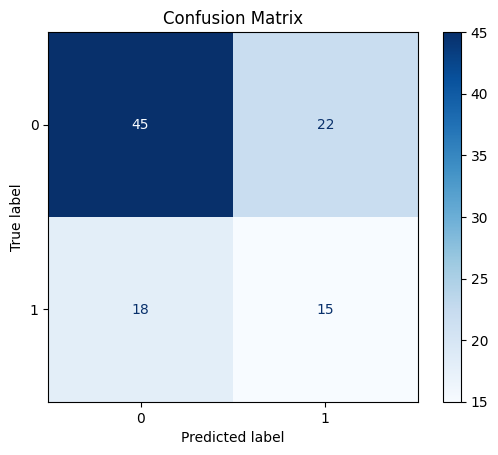

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

true_labels = []
predicted_labels = []
probs = []
# Set model to evaluation mode
model.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        # Get model outputs
        outputs = model(inputs)  # Raw logits
        
        # Apply sigmoid activation
        probabilities = torch.sigmoid(outputs)
        
        # Compute argmax for class prediction
        predictions = torch.argmax(probabilities, dim=1)
        
        # Store true and predicted labels
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())
        probs.extend(probabilities.cpu().numpy())

# Convert to NumPy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)
probs = np.array(probs)


pearson_corr, _ = pearsonr(true_labels, probs[:, 1])
print(f"Pearson correlation coefficient: {pearson_corr}")

kendall_tau, _ = kendalltau(true_labels, probs[:, 1])
print(f"Kendall's tau correlation: {kendall_tau}")
# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig("dl.png")
plt.show()

## Robustness study

In [ ]:
test_bench = pd.read_parquet("../llama3-70b-8192/faithful_4.parquet")
test_1 = pd.read_parquet("../llama3-70b-8192/faithful_4_1.parquet")
test_2 = pd.read_parquet("../llama3-70b-8192/faithful_4_2.parquet")
test_3 = pd.read_parquet("../llama3-70b-8192/faithful_4_3.parquet")

idx = test_bench.sort_values(by="faithfulness").index
test_bench = test_bench.loc[idx]
test_1 = test_1.loc[idx]
test_2 = test_2.loc[idx]
test_3 = test_3.loc[idx]
test_bench["faithfulness1"] = test_1["faithfulness"]
test_bench["faithfulness2"] = test_2["faithfulness"]
test_bench["faithfulness3"] = test_3["faithfulness"]
rho1 = np.corrcoef(test_bench["faithfulness"], test_bench["faithfulness1"])
rho2 = np.corrcoef(test_bench["faithfulness"], test_bench["faithfulness2"])
rho3 = np.corrcoef(test_bench["faithfulness"], test_bench["faithfulness3"])
rho4 = np.corrcoef(test_bench["faithfulness2"], test_bench["faithfulness3"])
rho5 = np.corrcoef(test_bench["faithfulness1"], test_bench["faithfulness2"])
rho6 = np.corrcoef(test_bench["faithfulness1"], test_bench["faithfulness3"])
plt.scatter(
    test_bench["faithfulness"] / 2,
    test_bench["faithfulness1"] / 2,
    marker="x",
    label=f"data 1->2 corr={rho2[0, 1]:2f}",
)
plt.scatter(
    test_bench["faithfulness"] / 2,
    test_bench["faithfulness2"] / 2,
    marker="x",
    label=f"data 1->3 corr={rho2[0, 1]:2f}",
)
plt.scatter(
    test_bench["faithfulness"] / 2,
    test_bench["faithfulness3"] / 2,
    marker="x",
    label=f"data 1->4 corr={rho3[0, 1]:2f}",
)
plt.scatter(
    test_bench["faithfulness2"] / 2,
    test_bench["faithfulness3"] / 2,
    marker="x",
    label=f"data 3->4 corr={rho4[0, 1]:2f}",
)
print([rho1[0, 1], rho2[0, 1], rho3[0, 1], rho4[0, 1], rho5[0, 1], rho6[0, 1]])
plt.legend()
plt.plot([0, 1], [0, 1], "k--", label="$y=x$")

plt.title("llama3-70b-8192")
plt.xlabel("faithfulness on left side")
plt.ylabel("faithfulness on ride side")

FileNotFoundError: [Errno 2] No such file or directory: '../llama3-70b-8192/faithful_4.parquet'

[0.6241648133640948, 0.5983287618020778, 0.5992270596844883, 0.570183939402625, 0.6432532271743, 0.47536152306578816]


Text(0, 0.5, 'AR on $k$th gen')

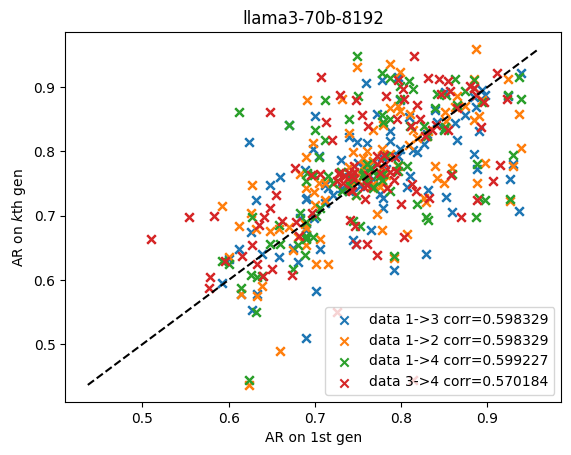

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

test_bench = pd.read_parquet("./llama3-70b-8192/AR_4.parquet")
test_1 = pd.read_parquet("./llama3-70b-8192/AR_4_1.parquet")
test_2 = pd.read_parquet("./llama3-70b-8192/AR_4_2.parquet")
test_3 = pd.read_parquet("./llama3-70b-8192/AR_4_3.parquet")

idx = test_bench.sort_values(by="AR").index
test_bench = test_bench.loc[idx]
test_1 = test_1.loc[idx]
test_2 = test_2.loc[idx]
test_3 = test_3.loc[idx]
test_bench["AR1"] = test_1["AR"]
test_bench["AR2"] = test_2["AR"]
test_bench["AR3"] = test_3["AR"]

rho1 = np.corrcoef(test_bench["AR"], test_bench["AR1"])
rho2 = np.corrcoef(test_bench["AR"], test_bench["AR2"])
rho3 = np.corrcoef(test_bench["AR"], test_bench["AR3"])
rho4 = np.corrcoef(test_bench["AR2"], test_bench["AR3"])
rho5 = np.corrcoef(test_bench["AR1"], test_bench["AR3"])
rho6 = np.corrcoef(test_bench["AR1"], test_bench["AR2"])
plt.scatter(
    test_bench["AR"],
    test_bench["AR2"],
    marker="x",
    label=f"data 1->3 corr={rho2[0, 1]:2f}",
)
plt.scatter(
    test_bench["AR"],
    test_bench["AR1"],
    marker="x",
    label=f"data 1->2 corr={rho2[0, 1]:2f}",
)
plt.scatter(
    test_bench["AR"],
    test_bench["AR3"],
    marker="x",
    label=f"data 1->4 corr={rho3[0, 1]:2f}",
)
plt.scatter(
    test_bench["AR2"],
    test_bench["AR3"],
    marker="x",
    label=f"data 3->4 corr={rho4[0, 1]:2f}",
)
print([rho1[0, 1], rho2[0, 1], rho3[0, 1], rho4[0, 1], rho5[0, 1], rho6[0, 1]])

plt.legend()
plt.plot(
    [test_bench.min().min(), test_bench.max().max()],
    [test_bench.min().min(), test_bench.max().max()],
    "k--",
    label="$y=x$",
)

plt.title("llama3-70b-8192")
plt.xlabel("AR on 1st gen")
plt.ylabel("AR on $k$th gen")